# Constrained Shock Alignment for Multiblock Structured Grids

# Preamble
* Define \vec for LaTeX $\newcommand{vec}[1]{\boldsymbol{#1}}$

In [1]:
# Configure python
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve_banded

# Defaults for plots
mpl.rc('lines', linewidth=0.8, marker='.')

## Motivation

To obtain accurate hypersonic heating estimates for blunt capsule geometries, current state of the art requires aligning the the computational grid with the bow shock. DPLR accomplishes this periodically reseting the location of the freestream boundary as follows:

  1. DPLR identifies the location of the bow shock using a jump detector based on Mach number.
  2. DPLR then constructs a smooth outer boundary slightly upstream of the bow shock position.
  3. DPLR then redistributes mesh points between the wall and the new outer boundary
  
There are a few shortcomings with this approach as it is currently implemented: 

  1. Tailoring can only be performed for single layer topologies (all block must span from the wall to the free stream).
  2. With few exceptions, adaption will fail if the shock moves outwards and collides with the outer boundary. This is can occur when interpolating solutions to a finer grid as part of a mesh sequencing strategy. Therefore, tailoring must be done in stages where initially the outer boundary is significantly offset from the shock and then brought in over time.
  3. It is not possible to directly control the spacing of the grid at the shock. Instead, spacing at the shock is controlled by a combination of the spacing at the outer boundary and the margin from the boundary to the shock, which can be cumbersome.
  4. Similar to (3), the outer boundary margin for the $n$-th grid is computed based on the local grid spacing near the bow shock on the $n-1$st grid. Therefore, it typically takes several adaptions to reach a converged grid even if the bow shock is not moving appreciably.
  6. Since shock fitting is done periodically and is decoupled from the evolution of the flow field, each adaption disturbs the flow solution and introduces error that may takes many iterations to remove.
  7. The methods employed to smooth the outer boundary either push the outer boundary away from the shock in regions of high body curvature (ismooth=3) or have difficulty removing high-frequency tailoring errors (ismooth=1).
  
I propose replacing the current decoupled tailoring strategy with one that evolves the grid simultaneously with the solution variables in an attempt to fit a specifed plane in the mesh to the bow shock. It is believed that this method can address all the above shortcomings and greatly reduce the wall time required to obtain the tailored grid solution.


## Mathematical Formulation

### Definitions
Consider a structured grid consisting of a single body-fitted block. We will refer to this grid as our *background grid*. The only requirement on the background grid is that it be large enough to contain the bow shock; it need not be aligned with the shock. Let $\vec\zeta = [\zeta_1, \zeta_2, \zeta_3]$ be the curvilinear coordinates for the background grid. 

The *computational grid* is constructed from the background grid by specifying a distribution of points along each constant-$\zeta_1,\zeta_2$ grid line. As the solution evolves, we wish to align the computational grid with the bow shock. Let $\xi = [\xi_1, \xi_2, \xi_2]$ represent the curvilinear coordinate for the computational grid. 

Next, let $S(\vec\zeta)$ be the arc-length of the constant-$\zeta_1,\zeta_2$ geodesic connecting the point $\vec\zeta$ to the outer boundary of the background grid:

$$ S(\vec\zeta) = \left. \int_{\zeta_3}^{\zeta_3^{max}} \left\Vert \frac{\partial x}{\partial \zeta_3} \right\Vert d\zeta_3 \right\vert_{\zeta_1,\zeta_2=C} $$

Leveraging this definition, let $s_s(\zeta_1,\zeta_2)$ be a function that specifies the curvilinear distance to the bow shock for a given $\zeta_1,\zeta_2$. The location of the bow shock may be identified using any suitable jump detector.

$$ s_s(\zeta_1,\zeta_2) = S\left(\zeta_1,\zeta_2, \zeta_3^{shock}\right)$$

Additionally, let $s(\zeta_1,\zeta_2)$ be a function that specifies the location of the constant-$\xi_3$ isosurface in the computational grid that will be aligned with the bow shock. 

$$ s(\zeta_1, \zeta_2) = S\left(\zeta_1, \zeta_1, \zeta_3^{\xi_3=C}\right) $$

While specifying the location of the shock and the $\xi_3$ isosurfaces in terms of curvilinear distance complicates the shock fitting process, it also provides several benefits: 

  1. By locating these surfaces relative to the outer boundary of the background grid, it is possible to move the computational grid outwards if the shock begins to impinge on the outer boundary of the compuational grid. 
  
  2. This parameterization specifies shock location independently of how the grid points are distributed in the wall-normal direction. This allows shock shapes to be to be easily and accurataely transferred a more refined grid. 
  
  3. This approach guarantees that $s$ and $s_s$ are smooth, differentiable functions provided that: (1) the shock front itself is smooth, (2) the outer boundary of the background grid is smooth, and (3) a smooth interpolant is used to compute the curvilinear distance function. Note that it is not required that either the background or the computational grid to have a smooth interior. This is important because non-smooth volume grids are very common: when using algebraic grid generation techniques, edges or corners in the surface geometry will alway results in non-smooth volume grids.

### Grid Equation of Motion
In order to couple the grid tailoring process to the solution of the flow equations we must define an equation of motion that governs the evolution of the grid with respect to time. The approach adopted here will be to define a partial differential equation that governs the evolution of the constant-$\xi_3$ isosurface and use an algebraic grid distribution function to control the placement of grid points along constant-$\zeta_1,\zeta_2$ grid lines. By using a known, fixed algebraic distribution function the grid tailoring problem is reduced in dimensionality, greatly reducing the computational complexity of the problem.

The partial differential equation governing the constant-$\xi_3$ iso-surface is based on analogy with a spring-mass-damper network. For the moment, let's restrict ourselves to a 2D fitting problem on the domain $\zeta_1 \times \zeta_3$ and assume that  the true shock location, $s_s(\zeta_1)$ is known. We then distribute a  series of point masses along a chosen $\xi_3$-isocontour and denote the curilinear position of $i$-th mass as $s_i = s(\zeta_{1,i})$. The masses are then coupled as follows: 

  1. Each mass is coupled to the shock with a spring-damper pair, where the force is proportional to the difference in curvilinear position: 
  
$$ 
    f_i = -k  \left( s_i - s_s(\zeta_{1,i}) \right)
        - \mu \left( \dot{s}_i - \dot{s}_s(\zeta_{1,i}) \right) 
$$

  2. Additionally, each mass is connected to its nearest neigbor with a spring-damper pair that resists relative displacement between masses:
  
$$
    f_i = -k^\prime \left( s_i - s_{i+1} \right)
        - \mu^\prime \left( \dot{s}_i - \dot{s}_{i+1} \right)
$$

The resulting force balance for each mass in the network is second order differential equation of the following form:

$$
    m_i \ddot{s}_i = -k          \left( s_i - s_{s,i} \right)
                     +k^\prime   \left( s_{i-1} - 2s_i + s_{i+1} \right)
                     -\mu        \left( \dot{s}_i - \dot{s}_{s,i} \right)
                     +\mu^\prime \left( \dot{s}_{i-1} - 2\dot{s}_i + \dot{s}_{i+1} \right)
$$

Dividing by mass and generalizing to the continuous limit, we arrive at the following four-parameter, linear partial differential equation for the evolution of the $\xi_3$ isosurface:

$$
    \ddot{s} + 2\left(\zeta\omega - \zeta^\prime \omega^\prime \nabla_\xi^2 \right)\dot{s}
             + \left(\omega^2 - \omega^{\prime 2}\nabla_\xi^2 \right)s
             = 2\zeta\omega\dot{s}_s + \omega^2 s_s
$$

A few notes about this equation:

  1. In this context the scalar $\zeta$ represents a damping ratio and is distinct from the vector quantity $\vec\zeta$. 
  
  2. As written, the spatial gradient is taken with respect to the computational coordinates, $\vec\xi$. This implies that the steady state solution of the equation of motion is *not* grid independent. Rather, as the computational grid is refined the curvature in computional coordinates will be reduced and the $\xi_3$-isosurface will more accurately follow the shock.


### Steady Solution to the Grid Equation
To gain insight into the chacteristics of grid motion equation, let us first consider the limit of steady state. Setting all time derivatives to zero yields:

$$
  s - \epsilon^2 \nabla_\xi^2 s = s_s, 
$$

$$
  \epsilon = \omega^\prime/\omega
$$

Here we see that at steady state, the dynamic model will minimize the distance between the $\xi_3$ isosurface and the shock in a manner that balances fitting error against curvature of the isosurface. This suggests that the parameter $\epsilon$, which represents the ratio of the membrane stiffness to the stiffness of the force attacting the $\xi_3$-isosurface to the shock, should be small to maximize the accuracy of the fit. 

However, in some cases where the shock structure itself is non-smooth, larger values may be necessary in some cases to ensure the smoothness of the grid. The figures below show the steady state solution in 1D for step and ramp inputs with various values of $\epsilon$. The Laplacian operator is approximated using the classical 3-point centered finite difference scheme with linear extrapolation at the boundaries ($s_{-1} = 2s_0 - s_1$). This discretization results in a tridiagonal linear system which is directly inverted onto the $s_0$ function.

To my eye, an $\epsilon$ of ~2, looks to be a good number for non-smooth grids. Steps are smoothed over ~10 grid points to either side of the jump; ramps are smoothed using ~10 points total. 

<IPython.core.display.Javascript object>


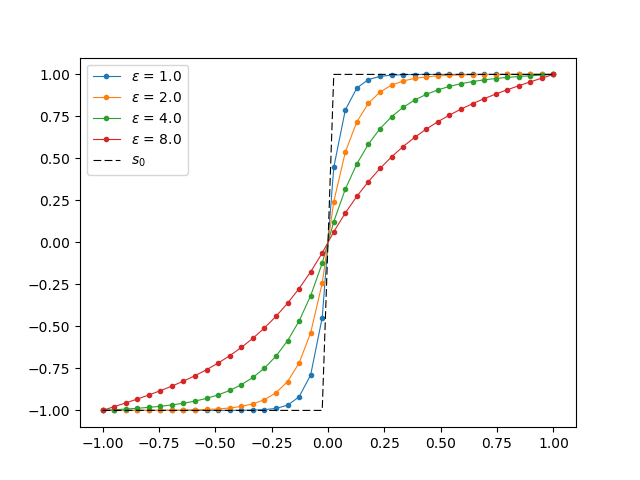

<IPython.core.display.Javascript object>


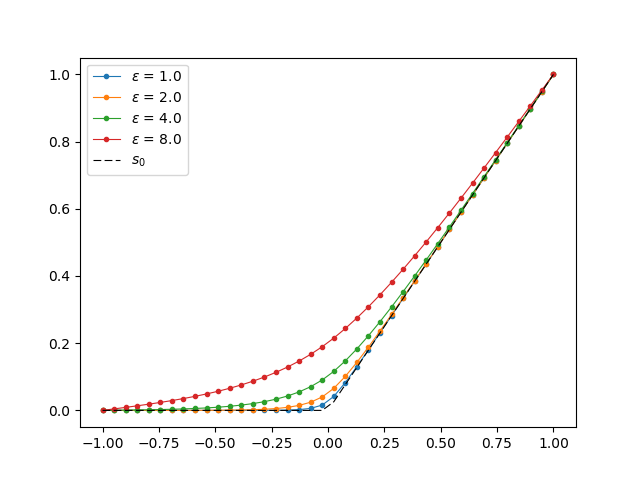

In [2]:
def generate_smoothing_matrix(epsilon, N):
    ''' Return rank-N tri-diagonal smoothing matrix in band-packed format '''
    
    # Baseline smoothing kernel
    main  = 1+2*epsilon**2 * np.ones(N)
    upper =    -epsilon**2 * np.ones(N)
    lower =    -epsilon**2 * np.ones(N)
    
    # Impose linear extrapolation boundry conditions    
    upper[ 0] = 0.0
    upper[ 1] = upper[ 1] +   epsilon**2
    main [ 0] = main [ 0] - 2*epsilon**2
    lower[-1] = 0.0
    lower[-2] = lower[-2] +   epsilon**2
    main [-1] = main [-1] - 2*epsilon**2
    
    return np.stack([upper, main, lower], axis=0)

def generate_function(input_type, N):
    ''' Returns an array with  specified function type'''  
    x = np.linspace(-1.0, 1.0, N)
    if input_type == "step":
        y = np.ones(N)
        y[x <= 0.0] = -1.0
    elif input_type == "ramp":
        y = x.copy()
        y[x <= 0.0] = 0.0
    else:
        raise RuntimeError("Unknown function")
    return x,y

# Plot effect of smoothing
npoint = 40
epsilon = [1.0, 2.0, 4.0, 8.0]
for function_type in ["step", "ramp"]:
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    x,s0 = generate_function(function_type, npoint)
    for eps in epsilon:
        A = generate_smoothing_matrix(eps, npoint)
        s = solve_banded((1,1), A, s0)
        ax.plot(x,s)
    ax.plot(x, s0, linestyle='dashed', color='black', marker='None')
    ax.legend(['$\epsilon$ = %.1f' % e for e in epsilon] + ['$s_0$'])



### Dynamic Response of the Grid Equation

To understand the dynamic behavior of our motion model, let us solve for the homogeneous dynamics of equation (?) in one dimension on an infinite interval. Since our partial differential equation is linear, solution via Fourier Transform is an expedient approach. Let,

$$
    s(t,\xi) = A_k(t)e^{ik\xi}
$$

Inserting this functional form into the governming equation yeilds a second order differential equation for the amplitude of the waveform: 

$$
    \ddot{A}_k 
    + 2\left(\zeta\omega + k^2\zeta^\prime\omega^\prime\right)\dot{A}_k
    + \left(\omega^2 + k^2\omega^{\prime 2}\right) A_k
    = 0
$$

This eqaution can be transformed into classical second order form by defining and effective damping ratio and angular rate, as shown below. 

$$
    \tilde{\omega} = \sqrt{ \omega^2 + k^2\omega^{\prime 2} } = \omega \sqrt{1 + k^2\epsilon^2}
$$

$$ 
    \tilde{\zeta} = \frac{\zeta\omega + k^2\zeta^\prime\omega^\prime}
                         {\sqrt{\omega^2 + k^2\omega^{\prime 2}}}
                  = \zeta \frac{1}{\sqrt{1 + k^2\epsilon^2}} 
                  + k\zeta^\prime \frac{k\epsilon}{\sqrt{1 + k^2\epsilon^2}} 
$$

$$
    \ddot{A}_k 
    + 2\tilde{\zeta}\tilde{\omega}\dot{A}_k
    + \tilde{\omega}^2 A_k
    = 0
$$

For $\tilde{\zeta} > 1$, the solution this equation is a linear sum of two exponential decay modes. Let

$$
    A_k(t) = A_{k0} e^{-t/\tau}
$$

Substituting into the differential equation for $A_k$, we arrive at a quadratic equation for $1/\tau$, which can be solved to yeild the chacateristice time constant for the two decay modes:

$$
    \frac{1}{\tau} = \tilde{\omega}\left(\tilde{\zeta} \pm \sqrt{\tilde\zeta^2 - 1}\right)
$$

This characteristic time constant is a function of four parameters: $\omega$, $\zeta$, $\zeta^\prime$, and $\epsilon$. Note that if we set $k = 0$ in the above equation, i.e. if the starting soltuion to the differential equation is a constant offset, the effective damping ratio and angular rate reduce to $\zeta$ and $\omega$ respectively. Therefore, these parameters govern how quickly the $\xi_3$-isosurface approaches the shock in an average sense.

The other two parameters, $\zeta^\prime$ and $\epsilon$, come into play for high spatial wavenumbers. If we consider the limit $k\rightarrow\infty$, it is possible to show that these two parameters set the decay constants for high-$k$ waveforms:

$$
\begin{align}
    \lim_{k\rightarrow\infty} \frac{1}{\tau^+} 
    &= \lim_{k\rightarrow\infty} \tilde{\omega} \left(\tilde{\zeta} + \sqrt{\tilde\zeta^2 - 1}\right) \\
    &= \lim_{k\rightarrow\infty} \epsilon k^2 \omega\zeta^\prime \left( 1 + \sqrt{1 - \left(k\zeta^\prime\right)^{-2}} \right) \\
    &= 2\epsilon k^2 \omega\zeta^\prime = 2k^2 \omega^\prime\zeta^\prime
\end{align}
$$

$$
\begin{align}
    \lim_{k\rightarrow\infty} \frac{1}{\tau^-} 
    &= \lim_{k\rightarrow\infty} \tilde{\omega} \left(\tilde{\zeta} - \sqrt{\tilde\zeta^2 - 1}\right) \\
    &= \lim_{k\rightarrow\infty} \epsilon k^2 \omega \zeta^\prime \left( 1 + \sqrt{1 - \left( k\zeta^\prime \right)^{-2} } \right) \\
    &= \frac{\epsilon\omega}{2\zeta^\prime} = \frac{\omega^\prime}{2\zeta^\prime}
\end{align}
$$

To better understand the effect of $\epsilon,\zeta^\prime$, let's analyze how quickly disturbances damp relative to the "average" motion of the $\xi_3$-isosurface. To do this, we take the ratio of the time constants for the slow modes. 

$$
\delta(k) = \frac{\tau^-\big|_{k=k}}{\tau^-\big|_{k=0}}
$$

With some algebra, this ratio can be written as: 

$$
    \delta(k\epsilon) = \frac{\zeta - \sqrt{\zeta^2 -1}}{ b\zeta - \sqrt{b^2\zeta^2 - a^2}}
$$

$$
\begin{align}
    a &= \sqrt{1 + k^2\epsilon^2}  \\
    b &= 1 + \alpha k^2 \epsilon^2 \\
    \alpha &= \frac{1}{\epsilon}\cdot\frac{\zeta^\prime}{\zeta}
\end{align}
$$

Examining this equation, we see that the decay of higher order modes relative to the mean mode is a function of the scaled wavenumber, $k\epsilon$, with free parameters $\zeta$ and $\alpha$. 
Since it is proportional to $\zeta^\prime$ and $\epsilon$, the $\alpha$ parameter controls the decay time for high-frequency waves. Note in Figure 3 below how the curves converge to $\alpha = 0.6$ as the damping ratio for the mean mode is increased. 

Of particular interest, Figure 4 shows that for large $\alpha$ the decay ratio switches from monotonically decreasing to monotonically increasing. This is undesireable as it implies that the high frequency fitting errors will damp more slowly than the mean offset. In the context of shock fitting, as the $\xi_3$-isosurface converges to the shock it will "overshoot" in some regions and then converge to the shock from the downstream side. We would prefer that the grid evolve to eliminate as much high-frequncy error as possible early in the fitting process and then converge to the shock from the upstream side in a uniform manner. This behavior can be obtained by selecting parameters that results in a monotonically decreasing decay ratio.



<IPython.core.display.Javascript object>


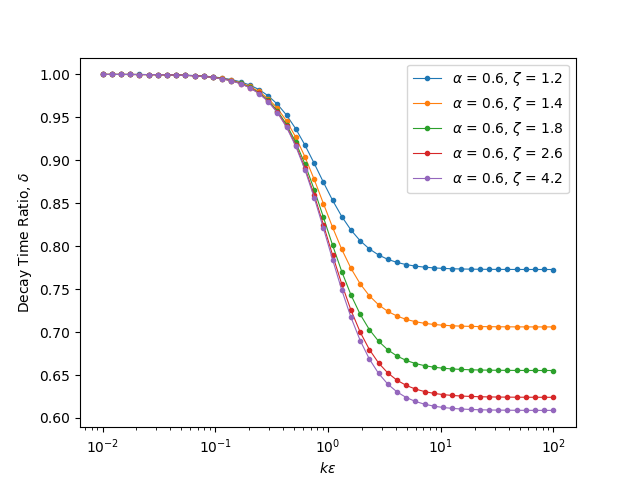

<IPython.core.display.Javascript object>


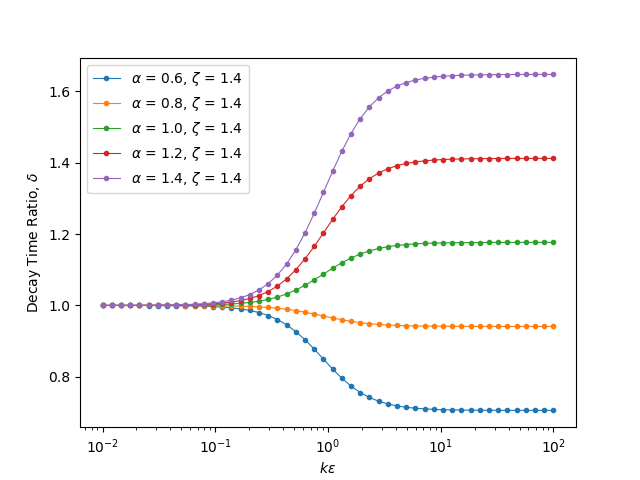

In [39]:
def compute_decay_ratio(ke, zeta, alpha):
    a = np.sqrt(1 + ke**2)
    b = 1 + alpha * ke**2
    return (zeta - np.sqrt(zeta**2 - 1))/(b*zeta - np.sqrt((b*zeta)**2 - a**2))

ke = np.logspace(-2, 2)

# Plot influence of increasing zeta
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'$k\epsilon$')
ax.set_ylabel(r'Decay Time Ratio, $\delta$')
alpha = 0.6
zeta = [1.2, 1.4, 1.8, 2.6, 4.2]
for z in zeta:
    ax.semilogx(ke, compute_decay_ratio(ke, z, alpha))
ax.legend([r'$\alpha$ = %.1f, $\zeta$ = %.1f' % (alpha, z) for z in zeta])
    
# Plot influence of increasing alpha
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'$k\epsilon$')
ax.set_ylabel(r'Decay Time Ratio, $\delta$')
alpha = [0.6, 0.8, 1.0, 1.2, 1.4]
zeta = 1.4
for a in alpha:
    ax.semilogx(ke, compute_decay_ratio(ke, zeta, a))
ax.legend([r'$\alpha$ = %.1f, $\zeta$ = %.1f' % (a,zeta) for a in alpha])
